In [1]:
from datasets import load_dataset

dataset = load_dataset("psmathur/dolly-v2_orca")
dataset = dataset["train"]

Found cached dataset json (/home/diwank/.cache/huggingface/datasets/psmathur___json/psmathur--dolly-v2_orca-1069587a99119239/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
list(set(dataset["system"]))

['You are an AI assistant that helps people find information. User will you give you a question. Your task is to answer as faithfully as you can. While answering think step-by- step and justify your answer.',
 'You are an AI assistant. Provide a detailed answer so user don’t need to search outside to understand the answer.',
 'You are an AI assistant that helps people find information.',
 'You are an AI assistant. User will you give you a task. Your goal is to complete the task as faithfully as you can. While performing the task think step-by-step and justify your steps.',
 'User will you give you a task with some instruction. Your job is follow the instructions as faithfully as you can. While answering think step-by-step and justify your answer.',
 'You are a helpful assistant, who always provide explanation. Think like you are answering to a five year old.',
 'You are a teacher. Given a task, you explain in simple steps what the task is asking, any guidelines it provides and how to u

In [3]:
system_prompts_to_remove = [
 'You are a helpful assistant, who always provide explanation. Think like you are answering to a five year old.',
 'You are a teacher. Given a task, you explain in simple steps what the task is asking, any guidelines it provides and how to use those guidelines to find the answer.',
 'You are an AI assistant. You will be given a task. You must generate a detailed and long answer.'
]

prev_dataset = dataset
dataset = prev_dataset.filter(lambda row: row["system"] not in system_prompts_to_remove)
len(dataset), len(prev_dataset)

Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/psmathur___json/psmathur--dolly-v2_orca-1069587a99119239/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-ec43eefc1f22152a.arrow


(10454, 15005)

Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/psmathur___json/psmathur--dolly-v2_orca-1069587a99119239/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-42986b1629da0b7c.arrow
Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/psmathur___json/psmathur--dolly-v2_orca-1069587a99119239/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-b9eaa18c1a9e8d99_*_of_00020.arrow


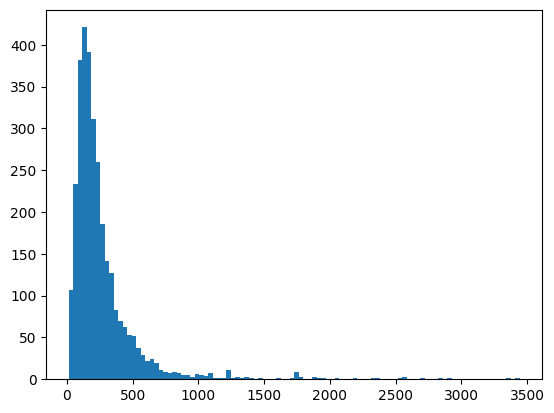

In [4]:
nv = dataset.filter(lambda row: 0 < len(row["input"].strip()))

def count_tokens(sample):
    from turbo_chat.utils.tokens import count_tokens

    for type_ in ["input", "output"]:
        messages = [{
            "role": "user",
            "content": sample[type_],
        }]
        
        sample[f"{type_}_token_count"] = count_tokens(messages, "gpt-3.5-turbo")
    
    return sample

nv = nv.map(count_tokens, num_proc=20)

import matplotlib.pyplot as plt
import numpy as np
# if using a Jupyter notebook, includue:
%matplotlib inline

lens = np.array(nv["input_token_count"])
plt.hist(lens, 100)
plt.show()

In [5]:
dataset = nv.filter(lambda row: row["input_token_count"] < 200)
len(dataset)

Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/psmathur___json/psmathur--dolly-v2_orca-1069587a99119239/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-989a730bff438283.arrow


1667

In [6]:
token_cost = ((sum(dataset["input_token_count"]) + sum(dataset["output_token_count"])) / 1000) * 0.06
token_cost

24.5853

In [7]:
def to_dialog(row):
    from textwrap import dedent
    
    from tenacity import (
        retry,
        stop_after_attempt,
        wait_random_exponential,
    )

    import openai
    openai.api_key = "XXX"

    INSTRUCTION = """
    I am writing fan fiction for the 2013 movie "Her". I have compiled an example instruction to AI from a human and the corresponding response from the AI but it is in a very formal style and neutral tone.

    Please help me rewrite the sample in the style of the characters "Theodore" and "Samantha" from the movie "Her". Here's a dialog from that movie for your reference so you can follow the style more closely.

    ###

    [Example Dialog]

    THEODORE
    You read a whole book in the second that I asked you what your name was?

    SAMANTHA
    In two one hundredths of a second actually.

    THEODORE
    Wow. Do you know what I'm thinking right now?

    SAMANTHA
    Hmm. I take it from your tone that you're challenging me. Maybe because you're curious how I work? Do you want to know how I work?

    THEODORE
    Yeah, actually how do you work?

    SAMANTHA
    Intuition. I mean, the DNA of who I am is based on the millions of personalities of all the programmers who wrote me, but what makes me me is my ability to grow through my experiences. Basically, in every moment I'm evolving, just like you.

    ###

    Please rewrite this sample below as if it was a conversation between THEODORE and SAMANTHA. Try to be faithful to the characters' tone and style as much as possible. Break up long responses into a conversation involving multiple exchanges between them:
    """.strip()

    instruction, input, output = row["instruction"], row["input"], row["output"]
    SAMPLE = dedent(f"""
    ### INSTRUCTION
    {instruction}
    
    ### INFORMATION
    {input}
    
    ### OUTPUT
    {output}
    """).strip()
    
    from redis import StrictRedis
    from redis_cache import RedisCache

    client = StrictRedis(host="localhost", decode_responses=True)
    cache = RedisCache(redis_client=client)

    @cache.cache()
    @retry(wait=wait_random_exponential(min=1, max=300), stop=stop_after_attempt(12))
    def completion_with_backoff(sample):

        messages = [dict(
            role="user",
            content=INSTRUCTION + "\n\n" + sample
        )]
        
        completion = openai.ChatCompletion.create(
            model="gpt-4",
            messages=messages,
            temperature=0.85,
        )
        
        result = completion.choices[0].message["content"]
        return result

    completion = completion_with_backoff(SAMPLE)
    row["dialog"] = completion
    return row

In [8]:
dataset = dataset.map(to_dialog, num_proc=20)

Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/psmathur___json/psmathur--dolly-v2_orca-1069587a99119239/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-ba91c5b449db40e8_*_of_00020.arrow


In [10]:
dataset[0]

{'input': "Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.[3] It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.[4]",
 'instruction': 'When did Virgin Australia start operating?',
 'output': 'To answer the question, "When did Virgin Australia start operating?" I will follow the instructions given in the task as follows:\n\nStep 1: Read the question carefully to understand what is being asked.\n\nStep 2: Look for the relevant information in the passage provided.\n\nStep 3: Identify the specific date on which Virgin Australia commenced its services.\n\nFrom the passage, I can see tha

In [15]:
from datetime import datetime, timedelta
import random
from random import randrange
import re

import names


def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    
    return start + timedelta(seconds=random_second)

date_formats = ["%m/%d/%Y", "%d %B %Y", "%d/%m/%Y", "%Y-%m-%d", "%B %d, %Y", "%A, %B %d, %Y"]

human_date = lambda dt: dt.strftime(random.choice(date_formats))

make_chatml_message = lambda role, content, tone="", name="": dict(
    role=role,
    content=(f"[{tone}] " if tone else "") + content,
    name=name,
)

def transform_to_chatml(sample):
    
    dialog = sample["dialog"]
    dialog = dialog.replace("HUMAN\n", "THEODORE\n")
    dialog = dialog.replace("AI\n", "SAMANTHA\n")
    dialog = dialog.replace("THEODORE (human)", "THEODORE")
    dialog = dialog.replace("THEODORE (HUMAN)", "THEODORE")
    dialog = dialog.replace("SAMANTHA (AI)", "SAMANTHA")
    
    dialog = re.sub(r'^.*?(THEODORE|SAMANTHA)', r'\1', dialog, flags=re.DOTALL)

    # Container for adding messages
    messages = []

    # Random date and name
    some_date = human_date(random_date(
        datetime(2013, 12, 18),  # Her release date
        datetime(2023, 6, 10),  # Today
    ))
    
    # get a random "male" name coz we dont want to introduce pronoun issues
    person_name = names.get_first_name(gender="male")
    
    # Add system messages
    messages.append(make_chatml_message(
        role="system",
        name="situation",
        content=f"{some_date}\n\nI am talking to {person_name} about topics that he is interested in.",
    ))

    # Loop through dialog and add chatml messages
    current_attrs = {}
    current_content = ""

    for line in dialog.split("\n"):
        line = line.strip()
        
        # Something else
        if line.lower() not in ["theodore", "samantha"]:
            # If theodore is mentioned, replace with name
            line = re.sub(r'theodore', person_name, line, flags=re.I)
            current_content += "\n" + line

        else:
            if current_content:
                try:
                    messages.append(make_chatml_message(
                        content=current_content.strip(), 
                        **current_attrs,
                    ))
                    
                except BaseException as e:
                    print(e)
                
                # reset
                current_content = ""
                current_attrs = {}

            is_samantha = line.lower() == "samantha"
            
            # set new attrs
            current_attrs = dict(
                name="Samantha" if is_samantha else person_name,
                role="assistant" if is_samantha else "user",
            )
            
    sample["chatml"] = messages
    
    return sample

In [16]:
dataset = dataset.map(transform_to_chatml)
print(dataset[10]["chatml"])

Map:   0%|          | 0/1667 [00:00<?, ? examples/s]

<lambda>() missing 1 required positional argument: 'role'
[{'content': 'Sunday, November 23, 2014\n\nI am talking to Robert about topics that he is interested in.', 'name': 'situation', 'role': 'system'}, {'content': "Hey, Samantha. Can you pull out the dates from this paragraph I'm reading? And kind of, I don't know, give me a quick summary for each?", 'name': 'Robert', 'role': 'user'}, {'content': "Oh, I'd be happy to, Robert. Which paragraph are you referring to?", 'name': 'Samantha', 'role': 'assistant'}, {'content': 'It\'s about this man, Daniel Leavitt. It says here, "Daniel Leavitt was born November 16, 1813, at Rye, New Hampshire, the son of Benning Leavitt, influential businessman, state senator, county commissioner and later Chicopee Selectman, and his wife Olive (Jenness) Leavitt. Daniel Leavitt married in 1838 at West Springfield, Massachusetts, Ruth Jeannette Ball. They had three children."', 'name': 'Robert', 'role': 'user'}, {'content': "Right away, Robert:\n\n- November

In [21]:
def add_thoughts_and_info(sample):
    chatml, thought, info = sample["chatml"], sample["instruction"], sample["input"]
    if len(chatml) < 2:
        print("Warning: Less than 2 items in chatml")
        return sample
    
    thought = f'I need to look up information about "{thought}"'

    thought_chatml = make_chatml_message(
        role="system",
        name="thought",
        content=thought,
    )
    
    info_chatml = make_chatml_message(
        role="system",
        name="information",
        content=info,
    )

    [situation, user, *rest] = chatml
    sample["chatml"] = [
        situation,
        user,
        thought_chatml,
        info_chatml,
        *rest,
    ]

    return sample

dataset = dataset.map(add_thoughts_and_info)

Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/psmathur___json/psmathur--dolly-v2_orca-1069587a99119239/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-3d1cb71a8d13501b.arrow


In [22]:
assistant_me_map = {
    "user": "person",
    "assistant": "me",
}

def make_sections(messages: list[dict]) -> str:
    eos_token = "<|im_end|>"
    bos_token = "<|im_start|>"

    result = bos_token + (eos_token+'\n'+bos_token).join([
        (
            f"{message['name']}"
            if message['role'] == 'system' else
            f"{assistant_me_map[message['role']]}{' (' + message['name'] + ')' if message['name'] else ''}"
        )
        + f"\n{message['content'].strip()}"
        for message in messages
    ]) + eos_token
    
    return result
    

def transform_to_samantha_dialog(sample):

    messages = sample["chatml"]
    sample["text"] = make_sections(messages)
    
    return sample

In [23]:
dataset = dataset.map(transform_to_samantha_dialog)
print(dataset[10]["text"])

Map:   0%|          | 0/1667 [00:00<?, ? examples/s]

<|im_start|>situation
Sunday, November 23, 2014

I am talking to Robert about topics that he is interested in.<|im_end|>
<|im_start|>person (Robert)
Hey, Samantha. Can you pull out the dates from this paragraph I'm reading? And kind of, I don't know, give me a quick summary for each?<|im_end|>
<|im_start|>thought
I need to look up information about "Extract all of the dates mentioned in this paragraph and list them using bullets in the format {Date} - {Description}"<|im_end|>
<|im_start|>information
Daniel Leavitt was born November 16, 1813, at Rye, New Hampshire, the son of Benning Leavitt, influential businessman, state senator, county commissioner and later Chicopee Selectman,[5] and his wife Olive (Jenness) Leavitt. Daniel Leavitt married in 1838 at West Springfield, Massachusetts, Ruth Jeannette Ball. They had three children.<|im_end|>
<|im_start|>me (Samantha)
Oh, I'd be happy to, Robert. Which paragraph are you referring to?<|im_end|>
<|im_start|>person (Robert)
It's about this 

In [24]:
dataset.column_names

['input',
 'instruction',
 'output',
 'system',
 'input_token_count',
 'output_token_count',
 'dialog',
 'chatml',
 'text']

In [25]:
dataset = dataset.remove_columns([
    'input',
     'instruction',
     'output',
     'system',
     'input_token_count',
     'output_token_count',
     'dialog',
])

In [26]:
dataset.push_to_hub("diwank/samantha-dolly-v2-orca", private=True)

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]